## 1. 라이브러리 및 데이터 로드

In [20]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
import os

# 경로 설정
data_dir = Path("../data")

# matplotlib 캐시 디렉터리를 임시 폴더로 설정 (권한 문제 회피)
import tempfile
temp_cache = tempfile.gettempdir()
os.environ['MPLCONFIGDIR'] = temp_cache

# matplotlib 폰트 캐시 완전 삭제 (안전하게)
import matplotlib
cache_dir = matplotlib.get_cachedir()
import shutil
try:
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
        print(f"✓ 폰트 캐시 삭제: {cache_dir}")
except Exception as e:
    print(f"캐시 삭제 스킵 (무시 가능): {e}")

# 폰트 매니저 강제 재로드
try:
    fm._load_fontmanager(try_read_cache=False)
except:
    pass

# 경고 필터링 (먼저 설정)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# 스타일 설정 (폰트 설정 전에 실행)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 한글 폰트 찾기
font_list = [f.name for f in fm.fontManager.ttflist]
korean_fonts = [f for f in font_list if 'Gothic' in f or 'Malgun' in f or 'Nanum' in f]

if korean_fonts:
    # Malgun Gothic 우선 선택
    if 'Malgun Gothic' in korean_fonts:
        selected_font = 'Malgun Gothic'
    elif 'NanumGothic' in korean_fonts:
        selected_font = 'NanumGothic'
    else:
        selected_font = korean_fonts[0]
    print(f"✓ 사용 가능한 한글 폰트: {korean_fonts[:5]}")
    print(f"✓ 선택된 폰트: {selected_font}")
else:
    selected_font = 'DejaVu Sans'
    print("⚠ 한글 폰트를 찾을 수 없습니다.")

# 폰트 설정 - 스타일 적용 후 다시 설정 (이게 핵심!)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [selected_font, 'DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

print(f"\n✓ 폰트 설정 완료")
print(f"  Font family: {plt.rcParams['font.family']}")
print(f"  Sans-serif list: {plt.rcParams['font.sans-serif'][:3]}")


Could not save font_manager cache [Errno 2] No such file or directory: 'C:\\Users\\kimt9\\.matplotlib\\fontlist-v390.json.matplotlib-lock'


✓ 사용 가능한 한글 폰트: ['MS Gothic', 'NanumGothic', 'BIZ UDGothic', 'Century Gothic', 'Franklin Gothic Demi Cond']
✓ 선택된 폰트: Malgun Gothic

✓ 폰트 설정 완료
  Font family: ['sans-serif']
  Sans-serif list: ['Malgun Gothic', 'DejaVu Sans', 'Arial']


In [2]:
# 이벤트 및 태그 매핑 테이블 로드
event_mapping = pd.read_csv(data_dir / "eventid2name.csv")
tag_mapping = pd.read_csv(data_dir / "tags2name.csv")

print("이벤트 타입:")
print(event_mapping['event_label'].unique())
print(f"\n총 {len(event_mapping)} 개의 이벤트 타입")

이벤트 타입:
['Duel' 'Foul' 'Free Kick' 'Goalkeeper leaving line' 'Interruption'
 'Offside' 'Others on the ball' 'Pass' 'Save attempt' 'Shot']

총 36 개의 이벤트 타입


In [3]:
# 리그 선택 (시작은 England로)
league = "England"

# 이벤트 데이터 로드
with open(data_dir / f"events_{league}.json", 'r') as f:
    events_raw = json.load(f)

# 매치 데이터 로드
with open(data_dir / f"matches_{league}.json", 'r') as f:
    matches_raw = json.load(f)

print(f"로드된 이벤트 수: {len(events_raw):,}")
print(f"로드된 경기 수: {len(matches_raw):,}")

로드된 이벤트 수: 643,150
로드된 경기 수: 380


## 2. 데이터 전처리

In [4]:
# 이벤트 데이터를 DataFrame으로 변환
events_df = pd.DataFrame(events_raw)

# 위치 데이터 추출
events_df['start_x'] = events_df['positions'].apply(lambda x: x[0]['x'] if len(x) > 0 else None)
events_df['start_y'] = events_df['positions'].apply(lambda x: x[0]['y'] if len(x) > 0 else None)
events_df['end_x'] = events_df['positions'].apply(lambda x: x[1]['x'] if len(x) > 1 else None)
events_df['end_y'] = events_df['positions'].apply(lambda x: x[1]['y'] if len(x) > 1 else None)

# 태그 처리 - 여러 태그를 리스트로
events_df['tag_ids'] = events_df['tags'].apply(lambda x: [tag['id'] for tag in x] if isinstance(x, list) else [])

# 이벤트 이름 매핑
events_df = events_df.merge(
    event_mapping[['event', 'subevent', 'event_label', 'subevent_label']], 
    left_on=['eventId', 'subEventId'], 
    right_on=['event', 'subevent'],
    how='left'
)

# 경기 내 시간 순서 정렬
events_df = events_df.sort_values(['matchId', 'matchPeriod', 'eventSec']).reset_index(drop=True)

print(f"전처리 완료: {len(events_df):,} 이벤트")
events_df.head()

전처리 완료: 643,150 이벤트


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,id,start_x,start_y,end_x,end_y,tag_ids,event,subevent,event_label,subevent_label
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,177959171,49,49,31.0,78.0,[1801],8.0,85.0,Pass,Simple pass
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,177959172,31,78,51.0,75.0,[1801],8.0,83.0,Pass,High pass
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,177959173,51,75,35.0,71.0,[1801],8.0,82.0,Pass,Head pass
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,177959174,35,71,41.0,95.0,[1801],8.0,82.0,Pass,Head pass
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,177959175,41,95,72.0,88.0,[1801],8.0,85.0,Pass,Simple pass


In [5]:
# 매치 데이터 처리 - 각 경기의 홈/어웨이 팀 정보
match_info = []
for match in matches_raw:
    teams = match['teamsData']
    home_team = [t for t in teams.values() if t['side'] == 'home'][0]
    away_team = [t for t in teams.values() if t['side'] == 'away'][0]
    
    match_info.append({
        'matchId': match['wyId'],
        'home_team_id': home_team['teamId'],
        'away_team_id': away_team['teamId'],
        'home_score': home_team['score'],
        'away_score': away_team['score'],
        'winner': match['winner']
    })

matches_df = pd.DataFrame(match_info)
matches_df.head()

,matchId,home_team_id,away_team_id,home_score,away_score,winner
0,2500089,1646,1659,1,2,1659
1,2500090,1628,1627,2,0,1628
2,2500091,1673,1609,0,1,1609
3,2500092,1612,1651,4,0,1612
4,2500093,1611,1644,1,0,1611


## 3. VAEP 특징 생성

각 액션에 대해 다음 특징들을 추출합니다:
- 액션 타입 (패스, 슛, 드리블 등)
- 위치 정보 (x, y 좌표)
- 팀 정보
- 시간 정보
- 게임 상태

In [6]:
# 매치 정보 병합
events_df = events_df.merge(matches_df, on='matchId', how='left')

# 팀이 홈인지 어웨이인지 판단
events_df['is_home_team'] = events_df['teamId'] == events_df['home_team_id']

# 상대 팀 ID
events_df['opponent_team_id'] = events_df.apply(
    lambda row: row['away_team_id'] if row['is_home_team'] else row['home_team_id'], 
    axis=1
)

In [7]:
# 중요 태그 확인
def has_tag(tag_list, tag_id):
    return tag_id in tag_list

events_df['is_goal'] = events_df['tag_ids'].apply(lambda x: has_tag(x, 101))
events_df['is_assist'] = events_df['tag_ids'].apply(lambda x: has_tag(x, 301))
events_df['is_key_pass'] = events_df['tag_ids'].apply(lambda x: has_tag(x, 302))
events_df['is_counter_attack'] = events_df['tag_ids'].apply(lambda x: has_tag(x, 1901))

print(f"골: {events_df['is_goal'].sum()}")
print(f"어시스트: {events_df['is_assist'].sum()}")
print(f"키 패스: {events_df['is_key_pass'].sum()}")

골: 2007
어시스트: 617
키 패스: 2283


In [8]:
# 골 골대 거리 계산 (정규화된 좌표: 0-100)
def distance_to_goal(x, y, attacking_direction='right'):
    """골대까지의 유클리드 거리 계산"""
    if attacking_direction == 'right':
        goal_x, goal_y = 100, 50
    else:
        goal_x, goal_y = 0, 50
    
    return np.sqrt((x - goal_x)**2 + (y - goal_y)**2)

# 공격 방향 판단 (1H는 홈팀이 오른쪽 공격, 2H는 반대)
def get_attacking_direction(is_home, period):
    if period == '1H':
        return 'right' if is_home else 'left'
    else:  # 2H, E1, E2, P
        return 'left' if is_home else 'right'

events_df['attacking_direction'] = events_df.apply(
    lambda row: get_attacking_direction(row['is_home_team'], row['matchPeriod']),
    axis=1
)

events_df['distance_to_goal'] = events_df.apply(
    lambda row: distance_to_goal(row['start_x'], row['start_y'], row['attacking_direction']) 
    if pd.notna(row['start_x']) else None,
    axis=1
)

## 4. 게임 상태 특징 생성

각 액션 시점의 게임 상태를 나타내는 특징들

In [9]:
# 이전/다음 액션 정보 추가 (시간 윈도우)
events_df['prev_event'] = events_df.groupby('matchId')['event_label'].shift(1)
events_df['next_event'] = events_df.groupby('matchId')['event_label'].shift(-1)

events_df['prev_team'] = events_df.groupby('matchId')['teamId'].shift(1)
events_df['next_team'] = events_df.groupby('matchId')['teamId'].shift(-1)

# 시간 차이
events_df['time_diff'] = events_df.groupby('matchId')['eventSec'].diff()

# 팀이 공을 소유하고 있는지
events_df['team_possession_change'] = events_df['teamId'] != events_df['prev_team']

In [10]:
# 경기 시간 구간 (초 단위를 분 단위로)
period_map = {'1H': 0, '2H': 45, 'E1': 90, 'E2': 105, 'P': 120}
events_df['game_minute'] = events_df.apply(
    lambda row: period_map.get(row['matchPeriod'], 0) + row['eventSec'] / 60,
    axis=1
)

# 경기 구간 (전반/후반/연장 등)
events_df['period_code'] = events_df['matchPeriod'].map(period_map)

## 5. 라벨 생성: 득점/실점 여부

각 액션 이후 N초 내에 득점/실점이 발생했는지 확인 (보통 10초)

In [11]:
# 득점 이벤트 찾기
goal_events = events_df[events_df['is_goal']].copy()
print(f"총 골 수: {len(goal_events)}")

# 시간 윈도우 설정 (초)
TIME_WINDOW = 10

def label_goals_in_window(df, window=10):
    """각 액션 이후 window초 내에 득점/실점 라벨링"""
    df = df.copy()
    df['scores'] = False  # 이 팀이 득점
    df['concedes'] = False  # 이 팀이 실점
    
    for match_id in df['matchId'].unique():
        match_events = df[df['matchId'] == match_id].copy()
        goal_indices = match_events[match_events['is_goal']].index
        
        for goal_idx in goal_indices:
            goal_time = match_events.loc[goal_idx, 'eventSec']
            goal_period = match_events.loc[goal_idx, 'matchPeriod']
            goal_team = match_events.loc[goal_idx, 'teamId']
            
            # 같은 피리어드에서 window 초 이전 이벤트들 찾기
            window_mask = (
                (match_events['matchPeriod'] == goal_period) &
                (match_events['eventSec'] >= goal_time - window) &
                (match_events['eventSec'] < goal_time)
            )
            
            window_indices = match_events[window_mask].index
            
            # 득점한 팀의 액션은 'scores', 상대팀은 'concedes'
            for idx in window_indices:
                if match_events.loc[idx, 'teamId'] == goal_team:
                    df.loc[idx, 'scores'] = True
                else:
                    df.loc[idx, 'concedes'] = True
    
    return df

# 라벨링 수행 (시간이 걸릴 수 있음)
print("득점/실점 라벨링 중...")
events_df = label_goals_in_window(events_df, TIME_WINDOW)

print(f"득점으로 이어진 액션: {events_df['scores'].sum():,}")
print(f"실점으로 이어진 액션: {events_df['concedes'].sum():,}")

총 골 수: 2007
득점/실점 라벨링 중...
득점으로 이어진 액션: 4,556
실점으로 이어진 액션: 5,230
득점으로 이어진 액션: 4,556
실점으로 이어진 액션: 5,230


## 6. 특징 벡터 준비

머신러닝 모델을 위한 특징 선택 및 인코딩

In [12]:
# 특징 선택
feature_columns = [
    'eventId', 'subEventId',
    'start_x', 'start_y', 
    'end_x', 'end_y',
    'distance_to_goal',
    'is_home_team',
    'period_code',
    'game_minute',
    'team_possession_change',
    'time_diff'
]

# 결측치 처리
vaep_df = events_df[feature_columns + ['scores', 'concedes', 'matchId', 'teamId']].copy()
vaep_df = vaep_df.fillna(0)

print(f"VAEP 데이터셋 크기: {vaep_df.shape}")
print(f"\n특징 컬럼: {feature_columns}")
vaep_df.head()

VAEP 데이터셋 크기: (643150, 16)

특징 컬럼: ['eventId', 'subEventId', 'start_x', 'start_y', 'end_x', 'end_y', 'distance_to_goal', 'is_home_team', 'period_code', 'game_minute', 'team_possession_change', 'time_diff']


,eventId,subEventId,start_x,start_y,end_x,end_y,distance_to_goal,is_home_team,period_code,game_minute,team_possession_change,time_diff,scores,concedes,matchId,teamId
0,8,85,49,49,31.0,78.0,51.009803,True,0,0.045977,True,0.000000,False,False,2499719,1609
1,8,83,31,78,51.0,75.0,74.464757,True,0,0.082448,False,2.188201,False,False,2499719,1609
2,8,82,51,75,35.0,71.0,55.009090,True,0,0.109036,False,1.595338,False,False,2499719,1609
3,8,82,35,71,41.0,95.0,68.308125,True,0,0.135723,False,1.601207,False,False,2499719,1609
4,8,85,41,95,72.0,88.0,74.202426,True,0,0.171706,False,2.158971,False,False,2499719,1609


In [13]:
# 클래스 불균형 확인
print("득점 라벨 분포:")
print(vaep_df['scores'].value_counts())
print(f"\n득점 비율: {vaep_df['scores'].mean():.4%}")

print("\n실점 라벨 분포:")
print(vaep_df['concedes'].value_counts())
print(f"실점 비율: {vaep_df['concedes'].mean():.4%}")

득점 라벨 분포:
scores
False    638594
True       4556
Name: count, dtype: int64

득점 비율: 0.7084%

실점 라벨 분포:
concedes
False    637920
True       5230
Name: count, dtype: int64
실점 비율: 0.8132%


## 7. 데이터 분할 및 저장

In [14]:
# Train/Test 분할 (경기 단위로)
from sklearn.model_selection import train_test_split

unique_matches = vaep_df['matchId'].unique()
train_matches, test_matches = train_test_split(unique_matches, test_size=0.2, random_state=42)

train_df = vaep_df[vaep_df['matchId'].isin(train_matches)]
test_df = vaep_df[vaep_df['matchId'].isin(test_matches)]

print(f"훈련 경기 수: {len(train_matches)}")
print(f"테스트 경기 수: {len(test_matches)}")
print(f"\n훈련 이벤트 수: {len(train_df):,}")
print(f"테스트 이벤트 수: {len(test_df):,}")

훈련 경기 수: 304
테스트 경기 수: 76

훈련 이벤트 수: 514,524
테스트 이벤트 수: 128,626


In [15]:
# 데이터 저장
output_dir = Path("../VAEP")
output_dir.mkdir(exist_ok=True)

train_df.to_csv(output_dir / f"vaep_train_{league}.csv", index=False)
test_df.to_csv(output_dir / f"vaep_test_{league}.csv", index=False)
vaep_df.to_csv(output_dir / f"vaep_full_{league}.csv", index=False)

print(f"데이터 저장 완료: {output_dir}")

데이터 저장 완료: ..\VAEP


## 8. 기본 통계 분석

In [16]:
# 이벤트 타입별 득점 기여도
event_stats = events_df.groupby('event_label').agg({
    'scores': ['sum', 'mean'],
    'concedes': ['sum', 'mean'],
    'eventId': 'count'
}).round(4)

event_stats.columns = ['득점_합', '득점_비율', '실점_합', '실점_비율', '총_횟수']
event_stats = event_stats.sort_values('득점_비율', ascending=False)

print("이벤트 타입별 득점 기여도:")
event_stats

이벤트 타입별 득점 기여도:


,득점_합,득점_비율,실점_합,실점_비율,총_횟수
event_label,,,,,
Save attempt,71,0.0212,69,0.0206,3349
Shot,107,0.0127,1025,0.1213,8451
Duel,1691,0.0096,1696,0.0096,176688
Goalkeeper leaving line,11,0.0087,11,0.0087,1266
Others on the ball,443,0.0087,387,0.0076,51085
Pass,2012,0.0061,1762,0.0054,328657
Free Kick,213,0.0058,269,0.0074,36423
Foul,2,0.0002,2,0.0002,8138
Interruption,6,0.0002,9,0.0003,27535


In [17]:
print(f"현재 사용 중인 폰트: {plt.rcParams['font.family']}")
print(f"Sans-serif 폰트 목록: {plt.rcParams['font.sans-serif']}")


현재 사용 중인 폰트: ['sans-serif']
Sans-serif 폰트 목록: ['Arial', 'Liberation Sans', 'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif']


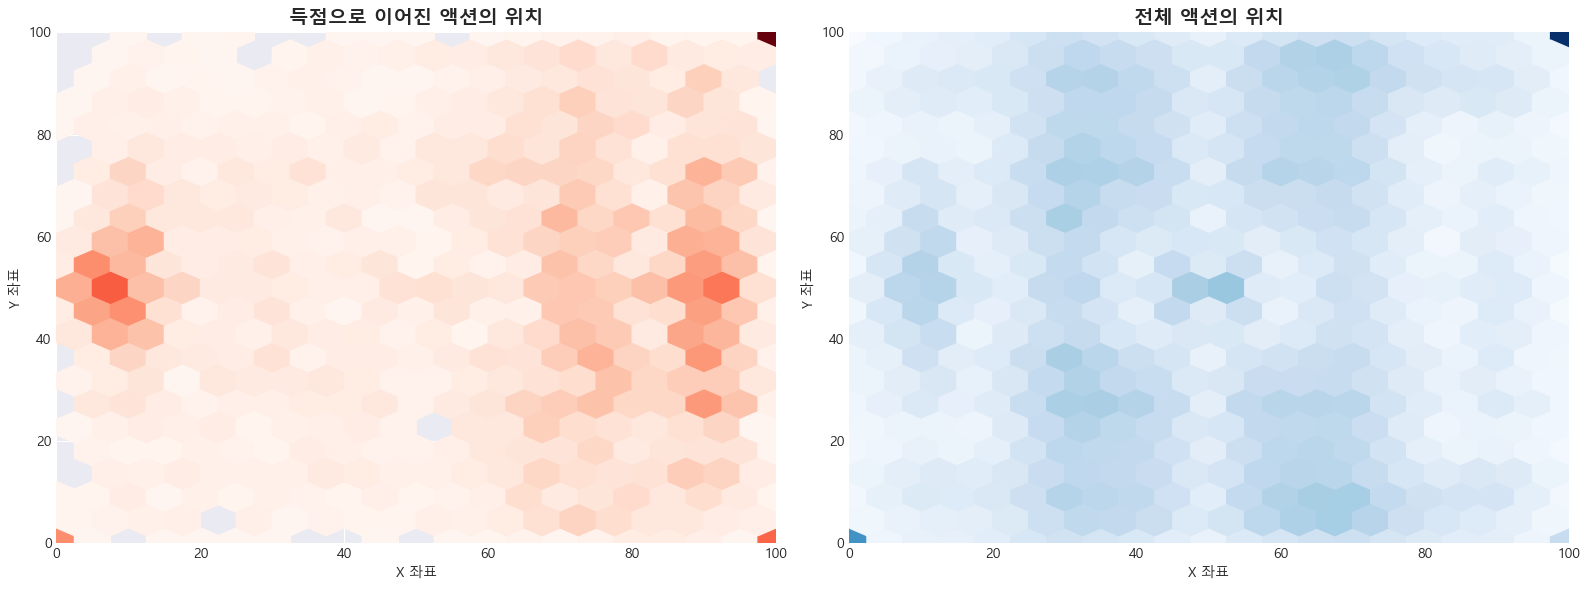

In [21]:

# 위치별 득점 확률 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 득점으로 이어진 액션의 시작 위치
scoring_actions = events_df[events_df['scores']]
axes[0].hexbin(scoring_actions['start_x'], scoring_actions['start_y'], 
               gridsize=20, cmap='Reds', mincnt=1)
axes[0].set_title('득점으로 이어진 액션의 위치', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X 좌표')
axes[0].set_ylabel('Y 좌표')
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)

# 모든 액션의 분포
axes[1].hexbin(events_df['start_x'], events_df['start_y'], 
               gridsize=20, cmap='Blues', mincnt=1)
axes[1].set_title('전체 액션의 위치', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X 좌표')
axes[1].set_ylabel('Y 좌표')
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

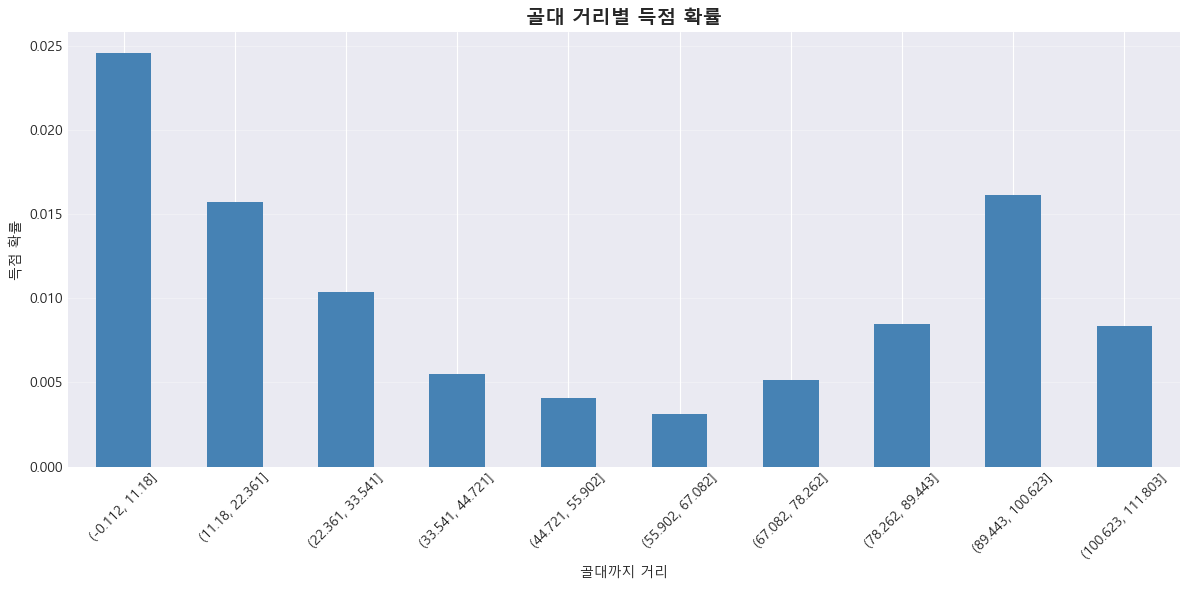


거리별 득점 통계:


,득점_수,총_액션,득점_확률
distance_to_goal,,,
"(-0.112, 11.18]",231,9394,0.024590
"(11.18, 22.361]",377,23991,0.015714
"(22.361, 33.541]",483,46466,0.010395
"(33.541, 44.721]",482,87715,0.005495
"(44.721, 55.902]",512,125948,0.004065
"(55.902, 67.082]",306,97061,0.003153
"(67.082, 78.262]",562,109428,0.005136
"(78.262, 89.443]",619,73062,0.008472
"(89.443, 100.623]",824,50997,0.016158


In [22]:
# 거리에 따른 득점 확률
distance_bins = pd.cut(events_df['distance_to_goal'], bins=10)
distance_stats = events_df.groupby(distance_bins, observed=False)['scores'].agg(['sum', 'count', 'mean'])
distance_stats.columns = ['득점_수', '총_액션', '득점_확률']

plt.figure(figsize=(12, 6))
distance_stats['득점_확률'].plot(kind='bar', color='steelblue')
plt.title('골대 거리별 득점 확률', fontsize=14, fontweight='bold')
plt.xlabel('골대까지 거리')
plt.ylabel('득점 확률')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n거리별 득점 통계:")
distance_stats

## 다음 단계

1. **모델 학습**: XGBoost, Random Forest 등을 사용하여 득점/실점 확률 예측 모델 학습
2. **VAEP 값 계산**: 각 액션의 VAEP = ΔP(득점) - ΔP(실점)
3. **선수 평가**: 선수별 누적 VAEP 값으로 기여도 평가
4. **시각화**: 선수/팀별 VAEP 분포, 시간대별 변화 등